## 목차
- step1 라이브러리 불러오기, 버전확인하기
- step2 dataset 불러오기
- step3 모델만들기
- step4 학습하기
- step5 훈련과정 시각화 하기
- 회고


## step 1 라이브러리 불러오기, 버전확인

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## step2 dataset 불러오기
- stanford dog data 사용

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteG8BNSS/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteG8BNSS/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


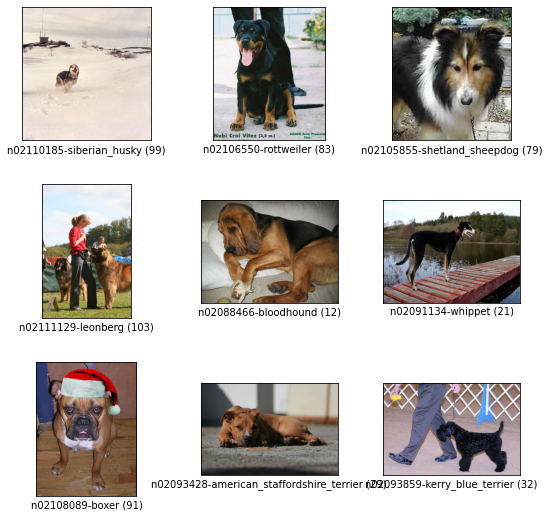

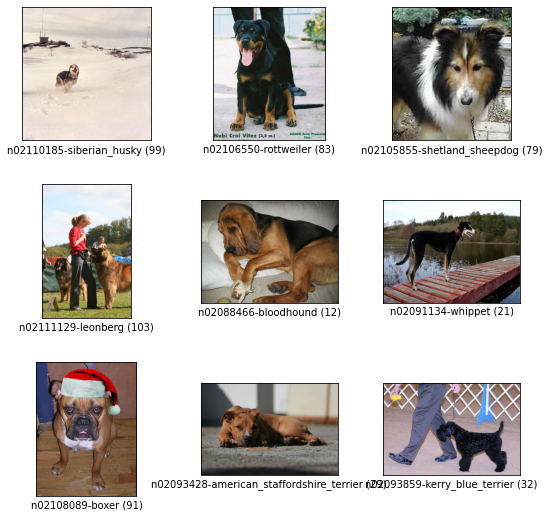

In [ ]:
tfds.show_examples(ds_train, ds_info)

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
# cutmix Augmentaion


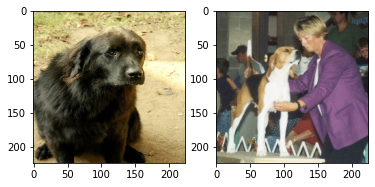

In [ ]:
import matplotlib.pyplot as plt

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [ ]:
def get_clip_box(image_a, image_b):
    #image.shape = (height, width, channel)
    image_size_x = image_a.shape[1] # width
    image_size_y = image_a.shape[0] # height

    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax box
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(64, shape=(), dtype=int32) tf.Tensor(82, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(76, shape=(), dtype=int32)


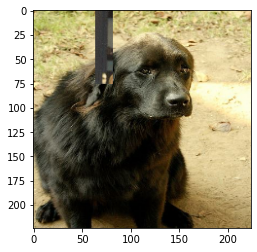

In [ ]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [ ]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02726403, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [ ]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


In [ ]:
# mixup Augmentation

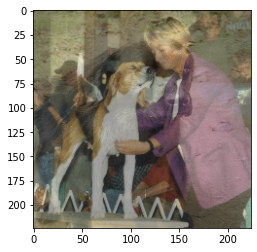

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.63231206 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [ ]:
# function for mixup
num_classes = ds_info.features["label"].num_classes
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [ ]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


In [ ]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

원본데이터를 Augmentation을 다양한 데이터 형태를 얻는 과정을 함수로 묶어서 표현
` apply_normalize_on_dataset`  
주의: Cutmix는 배치 안에 잇는 이미지끼리 섞는 과정이기 때문에, 배치 단위로 데이터셋을 정렬후 Cutmix 가 이루어져야한다.

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)

## step3 모델만들기
Resnet 모델을 활용합니다
- plain model - resnet50_no_aug
- augmentation model - resnet50_aug
- mixup augmentation model - resnet50_mixup
- Cutmix augmentation model - resnet50_cutmix

In [ ]:
# imagenet 데이터에 훈련된 ResNet50 모델 불러오기
resnet50_no_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,   # 마지막 fully connected layer 미포함
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')  # 데이터에 맞는 FC layer 붙여서 활용
])

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

## step4 학습하기
- epoch = 20으로 학습하기

In [ ]:
EPOCH = 50

resnet50_no_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history_resnet50_no_aug = resnet50_no_aug.fit(
    ds_train_no_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
750/750 [==============================] - 102s 117ms/step - loss: 2.2239 - accuracy: 0.4492 - val_loss: 3.2361 - val_accuracy: 0.2277
Epoch 2/50
750/750 [==============================] - 87s 115ms/step - loss: 0.6537 - accuracy: 0.8283 - val_loss: 1.0727 - val_accuracy: 0.6852
Epoch 3/50
750/750 [==============================] - 88s 117ms/step - loss: 0.1742 - accuracy: 0.9687 - val_loss: 0.9356 - val_accuracy: 0.7256
Epoch 4/50
750/750 [==============================] - 87s 116ms/step - loss: 0.0518 - accuracy: 0.9960 - val_loss: 0.9319 - val_accuracy: 0.7299
Epoch 5/50
750/750 [==============================] - 87s 116ms/step - loss: 0.0464 - accuracy: 0.9973 - val_loss: 0.9816 - val_accuracy: 0.7242
Epoch 6/50
750/750 [==============================] - 87s 116ms/step - loss: 0.0178 - accuracy: 0.9993 - val_loss: 0.9184 - val_accuracy: 0.7416
Epoch 7/50
750/750 [==============================] - 87s 116ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.9303 - val_a

In [ ]:
history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
750/750 [==============================] - 94s 116ms/step - loss: 2.2699 - accuracy: 0.4333 - val_loss: 3.0561 - val_accuracy: 0.2554
Epoch 2/50
750/750 [==============================] - 86s 115ms/step - loss: 0.9557 - accuracy: 0.7308 - val_loss: 1.1455 - val_accuracy: 0.6597
Epoch 3/50
750/750 [==============================] - 87s 115ms/step - loss: 0.4751 - accuracy: 0.8742 - val_loss: 1.1700 - val_accuracy: 0.6602
Epoch 4/50
750/750 [==============================] - 86s 115ms/step - loss: 0.2405 - accuracy: 0.9436 - val_loss: 1.0638 - val_accuracy: 0.7007
Epoch 5/50
750/750 [==============================] - 87s 116ms/step - loss: 0.1252 - accuracy: 0.9798 - val_loss: 1.0714 - val_accuracy: 0.7000
Epoch 6/50
750/750 [==============================] - 88s 118ms/step - loss: 0.0769 - accuracy: 0.9900 - val_loss: 1.0270 - val_accuracy: 0.7143
Epoch 7/50
750/750 [==============================] - 93s 124ms/step - loss: 0.0450 - accuracy: 0.9951 - val_loss: 0.9975 - val_ac

In [ ]:
history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
750/750 [==============================] - 96s 119ms/step - loss: 3.8670 - accuracy: 0.2068 - val_loss: 3.3953 - val_accuracy: 0.2024
Epoch 2/50
750/750 [==============================] - 88s 118ms/step - loss: 2.9358 - accuracy: 0.4289 - val_loss: 1.3437 - val_accuracy: 0.6226
Epoch 3/50
750/750 [==============================] - 88s 118ms/step - loss: 2.6235 - accuracy: 0.5371 - val_loss: 1.2141 - val_accuracy: 0.6589
Epoch 4/50
750/750 [==============================] - 88s 118ms/step - loss: 2.3908 - accuracy: 0.6138 - val_loss: 1.2896 - val_accuracy: 0.6419
Epoch 5/50
750/750 [==============================] - 88s 118ms/step - loss: 2.2673 - accuracy: 0.6557 - val_loss: 1.1591 - val_accuracy: 0.6839
Epoch 6/50
750/750 [==============================] - 88s 118ms/step - loss: 2.1496 - accuracy: 0.6914 - val_loss: 1.2249 - val_accuracy: 0.6692
Epoch 7/50
750/750 [==============================] - 88s 118ms/step - loss: 2.0374 - accuracy: 0.7201 - val_loss: 1.1178 - val_ac

In [ ]:
history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
750/750 [==============================] - 96s 119ms/step - loss: 3.7065 - accuracy: 0.2467 - val_loss: 4.0710 - val_accuracy: 0.1140
Epoch 2/50
750/750 [==============================] - 88s 118ms/step - loss: 2.8588 - accuracy: 0.4827 - val_loss: 1.5356 - val_accuracy: 0.5679
Epoch 3/50
750/750 [==============================] - 89s 118ms/step - loss: 2.5935 - accuracy: 0.5782 - val_loss: 1.4530 - val_accuracy: 0.5985
Epoch 4/50
750/750 [==============================] - 88s 118ms/step - loss: 2.3791 - accuracy: 0.6616 - val_loss: 1.2281 - val_accuracy: 0.6521
Epoch 5/50
750/750 [==============================] - 89s 118ms/step - loss: 2.2203 - accuracy: 0.7165 - val_loss: 1.3047 - val_accuracy: 0.6542
Epoch 6/50
750/750 [==============================] - 89s 118ms/step - loss: 2.1375 - accuracy: 0.7524 - val_loss: 1.2741 - val_accuracy: 0.6558
Epoch 7/50
750/750 [==============================] - 89s 118ms/step - loss: 2.0771 - accuracy: 0.7727 - val_loss: 1.5406 - val_ac

## step5 훈련과정 시각화하기

In [ ]:
plt.figure(figsize=(12,8))

plt.plot(history_resnet50_no_aug.history['val_accuracy'],'r')
plt.plot(history_resnet50_aug.history['val_accuracy'],'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'],'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'],'k')
plt.title('validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


plt.figure(figsize=(12,8))
plt.plot(history_resnet50_no_aug.history['val_loss'],'r')
plt.plot(history_resnet50_aug.history['val_loss'],'b')
plt.plot(history_resnet50_cutmix.history['val_loss'],'g')
plt.plot(history_resnet50_mixup.history['val_loss'],'k')
plt.title('validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['NO agumentatioin','augmentation','cutmix','mixup'], loc='upper right')
plt.grid(True)
plt.show()

## 회고
- mixup, cutmix 사용이유: CNN에서 Dropout은 Classfier의 성능을 강화시켜주는 요소로 사용되었다.지역적인 Dropout은 이미지를 훈련하는 과정중에 정보를 싣고 있는 픽셀을 제거하고 검은색 픽셀 혹은 임의의 노이즈 패치를 할당하여 이미지를 교육하게된다. 하지만 이런 학습법은 정보 손실과 비효울성으로 이어지기 때문에 적합하지 않다. 따라서 노이즈 또는 검은색 픽셀을 다른 레이블을 가진 이미지로 대체하여 성능을 향상을 노리는 전략을 떠올렸다고 한다. 따라서 cutmix는 하나의 이미지 안에 두개의 레이블을 가진 이미지를 적당한 비율로 배치하여 두 개의 레이블에 하나의 이미지에 비율을 맞게 배치되는 전략이다. 
- epoch 20으로 학습하였다. 학습시간이 적어서 그런지 cutmix, mixup을 적용하였을때 더 정확성이 떨어졌다. 그래서 왜 이것을 적용해야하지? 라는 생각이 들었다. 그래서 따로 epoch 50으로 설정하여 돌려보아야겠다. 
- 기본적인 augmentaion을 했을때 기본 resnet 보다 1퍼센트정도 정확도가 높게 나왔다. 엄청난 차이가 보여지는건 아니였기때문에 학습시간 부족인가 라는 생각을 하였다! 또한 stanford dog 데이터 특성상 새로운 데이터가 아니고, 기존에 많이 사용되는 데이터이기때문에 굳이 뉴런의 정보손실, mixup, cutmix를 적용하지 않아도 정확도가 상당히 높지 않을까.. 라는 생각도 하였다.

epoch 50 으로 학습한후 추가
- 별로 차이가 없었다. 왜 사용할까? 여전히 의문이 드는 부분